# Parámetros

In [1]:
CREDIT_FILE_ID = '18P5oXUpch9s5Nm4WdV_fwjX4oBneyyuh'
APPLICATION_FILE_ID = '1ET5jQSMcLj7odR1OttvR1qdcWtQ-CnaQ'
BASE_DIR = '/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data'

# Entorno

In [2]:
# Control de datos
from pathlib import Path
from requests import Session
from pickle import dump as save_pkl, load as load_pkl

# Ingeniería de variables
from numpy import nan
from pandas import DataFrame, read_csv, cut, qcut

# Modelos
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# Código

In [3]:
class BussinessCase:
    def __init__(self, base_dir: str=None) -> None:
        '''
        Sólo recibe el directorio de trabajo y la clase cuenta con los métodos suficientes para:
            - limpieza
            - entrenamiento
            - predicción
        '''
        # Define el directorio como objeto Path para manejar eficientemente los archivos y directorios
        if base_dir is not None: self.base_dir = Path(base_dir)
        else: self.base_dir = Path().cwd()
        self.main_dict = {}


    def get_file(self, file_id: str, file_name: str) -> DataFrame:
        '''
        Extrae los archivos via Google Drive
        '''
        # Hace la solicitud a la URL y guarda la respuesta
        session = Session()
        URL = "https://docs.google.com/uc?export=download"
        response = session.get(URL, params={'id':file_id, 'confirm':'t'}, stream=True)

        # Guarda el archivo en el directorio descrito
        file_dir = self.base_dir.joinpath(f'{file_name}.csv')
        with open(file_dir, "wb") as f:
            for chunk in response.iter_content(32768):
                f.write(chunk)

        df = read_csv(file_dir)
        return df

    
    def get_both_files(self, credit_file: tuple, app_file: tuple) -> None:
        self.credit = self.get_file(credit_file[0], credit_file[-1])
        self.app = self.get_file(app_file[0], app_file[-1])
        print(f'Los archivos:\n\t-{credit_file[-1]}.csv\n\t-{app_file[-1]}.csv\nfueron importados exitosamente')


    def mod_credit(self, id_col: str, status_col: str, date_col: str) -> DataFrame:
        cred = self.credit.replace({str(x):1 for x in range(1,6)})
        cred = cred.pivot_table(index=id_col, columns=date_col, values=status_col, aggfunc=lambda x:x)
        cred.fillna('Unknown', inplace=True)
        return cred.astype(str)


    def to_drop(self, df: DataFrame, col: str) -> None:
        df.drop(col, axis=1, inplace=True)
        return df


    def to_range(self, df: DataFrame, col: str, is_train: bool, **kwargs) -> None:
        # Función para convertir float: 1.0 --> str: '01'
        def two_char(n): return str(int(n)).zfill(2)
        # Encontrar el bin al cual el dato pertenece
        if is_train:
            df[col], self.main_dict['ranges'][col] = qcut(df[col], retbins=True, duplicates='drop', **kwargs)
        else: 
            df[col] = cut(df[col], bins=self.main_dict['ranges'][col])
        # Convertirlo a texto: [1.0 - 5.0] --> '01 a 05'
        df[col] = df[col].map(lambda x: two_char(x.left+1)+' a '+two_char(x.right) if x!=nan else nan)
        return df


    def to_flag(self, df: DataFrame, col: str, option_list: list) -> None:
        df[col] = df[col].map(lambda x: 0 if x in option_list else 1)
        return df


    def mod_app(self, id_col: str, to_drop_cols: list, to_range_cols: list, to_flag_cols: list, **kwargs) -> None:
        X = self.app.drop_duplicates(id_col)
        X = X[X[id_col].isin(self.credit[id_col])].copy()
        X.set_index(id_col, inplace=True)

        bc.main_dict['ranges'] = {}
        for col in to_drop_cols: X = self.to_drop(X, col)
        for col in to_range_cols: X = self.to_range(X, col, **kwargs)
        for col, opt in to_flag_cols: X = self.to_flag(X, col, opt)
        return X.astype(str)


    def train_model(self, X: DataFrame, y: DataFrame, prep, model, is_classif: bool, verbose: bool=True, **kwargs) -> tuple: 
        '''
        Escala y entrena un modelo, devuelve el score, el objeto tipo Pipeline y la relevancia de cada variable
        '''
        df = X.join(y)
        X = df.loc[:,:-1]
        X.columns = list(map(str, X.columns))
        y = df.loc[:,-1].values

        if is_classif:
            y_encod = LabelEncoder()
            # Las etiquetas serán etiquetadas numéricamente
            y = y_encod.fit_transform(y)
        else: y_encod = ''

        # Conjunto de entrenamiento y de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.87, random_state=22, shuffle=True)

        # Define los pasos del flujo
        pipe_obj = Pipeline(steps=[('prep', prep()), ('model', model(**kwargs))])

        # Entrena y guarda el score en test
        test_score = pipe_obj.fit(X_train, y_train).score(X_test, y_test)
        # Guarda el score en train, para revisar sobreajuste
        train_score = pipe_obj.score(X_train, y_train)

        # Imprime los scores
        if verbose: print(f"Score: {'{:.2%}'.format(test_score)}\nTraining score: {'{:.2%}'.format(train_score)}")
        return (pipe_obj, y_encod), (test_score, train_score), (X_train, y_train), (X_test, y_test)


    def cm_sklearn(self, X, y, fit_model, target_encoder) -> DataFrame:
        '''
        Muestra la matriz de confusión en un mapa de calor
        '''
        # Regresa los números a etiquetas originales
        labels = target_encoder.inverse_transform(fit_model.classes_)
        # Calcula la matriz de confusión, real vs estimado
        cm = DataFrame(confusion_matrix(y_true=y, y_pred=fit_model.predict(X)), index=labels, columns=labels).replace({0:nan})
        
        # Define el tamaño de el mapa de calor
        size = len(set(y))//2
        fig, ax = plt.subplots(figsize=(size,size)) 
        # Crea el mapa de calor con base en la distribución % del valor real a través de sus predicciones
        to_heatmap = DataFrame([cm[col] / cm.sum(axis=1) for col in cm.columns], index=labels, columns=labels).T
        sns.heatmap(to_heatmap, annot=True, fmt='.0%',cmap='Blues', linewidths=0.5, ax=ax, cbar=False)
        plt.show()
        return cm

    
    def save_model(self, model, model_name: str) -> None:
        '''
        Exporta el modelo en modo diccionario para que cuando se importe, se conozca de qué trata el objeto
        '''
        self.models_dir = self.base_dir.joinpath('model')
        self.models_dir.mkdir(exist_ok=True)

        self.main_dict[model_name] = model

        with open(self.models_dir.joinpath(f'{model_name}.xz'), 'wb') as f:
            # Como diccionario para conocer su nombre
            save_pkl(self.main_dict, f)

        print(f'El modelo {model_name}.xz ha sido guardado exitosamente en:\n{self.models_dir}')


    def get_model(self, model_name: str) -> None:
        with open(self.models_dir.joinpath(f'{model_name}.xz'), 'rb') as f:
            # Como diccionario para conocer su nombre
            model_dict = load_pkl(f)
            
        # Confirma que el archivo fue guardado exitosamente
        print(f'El modelo {model_name}.xz fue importado existosamente desde:\n{self.models_dir}')
        return model_dict

# Importar

In [4]:
bc = BussinessCase(BASE_DIR)
bc.get_both_files((CREDIT_FILE_ID, 'credit'), (APPLICATION_FILE_ID, 'app'))

Los archivos:
	-credit.csv
	-app.csv
fueron importados exitosamente


# Transformar

In [5]:
y = bc.mod_credit(id_col='ID', status_col='STATUS', date_col='MONTHS_BALANCE')
y.head()

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,0,0,0,X
5001712,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,0,C,C,C,C,C,C,C,C,C
5001713,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,X,X,X,X,X,X,X,X,X,X
5001714,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,...,X,X,X,X,X,X,X,X,X,X
5001715,Unknown,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X


In [6]:
X = bc.mod_app(
    id_col='ID',
    is_train=True,
    to_drop_cols=['FLAG_MOBIL'],
    to_range_cols=['AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS'], q=10,
    to_flag_cols=[
        ('CNT_CHILDREN',['0']),
        ('NAME_HOUSING_TYPE',['House / apartment']),
        ('OCCUPATION_TYPE', [nan])
    ]
)

X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,M,Y,Y,1,315001 a 1575000,Working,Higher education,Civil marriage,1,-13096 a -11822,-5344 a -3596,1,0,0,0,01 a 02
5008805,M,Y,Y,1,315001 a 1575000,Working,Higher education,Civil marriage,1,-13096 a -11822,-5344 a -3596,1,0,0,0,01 a 02
5008806,M,Y,Y,1,90001 a 112500,Working,Secondary / secondary special,Married,0,-22000 a -20295,-1551 a -1081,0,0,0,1,01 a 02
5008808,F,N,Y,1,247501 a 315000,Commercial associate,Secondary / secondary special,Single / not married,0,-20294 a -18614,-3595 a -2755,0,1,1,1,01 a 02
5008809,F,N,Y,1,247501 a 315000,Commercial associate,Secondary / secondary special,Single / not married,0,-20294 a -18614,-3595 a -2755,0,1,1,1,01 a 02


# Modelo

In [7]:
from sklearn.linear_model import LogisticRegression
from category_encoders.cat_boost import CatBoostEncoder

model, scores, train, test = bc.train_model(
    X, y,
    prep=CatBoostEncoder,
    model=LogisticRegression,
    class_weight='balanced',
    solver='liblinear',
    max_iter=10000,
    is_classif=True
)

Score: 95.86%
Training score: 96.00%


In [8]:
model[0]

Pipeline(steps=[('prep',
                 CatBoostEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR',
                                       'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
                                       'NAME_EDUCATION_TYPE',
                                       'NAME_FAMILY_STATUS',
                                       'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
                                       'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
                                       'FLAG_PHONE', 'FLAG_EMAIL',
                                       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
                                       '-60', '-59', '-58', '-57', '-56', '-55',
                                       '-54', '-53', '-52', '-51', '-50', '-49',
                                       '-48', '-47', ...])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    solver='liblinear'))])

# Resultados

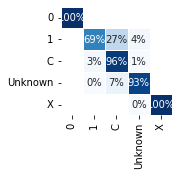

In [9]:
conf = bc.cm_sklearn(test[0], test[-1], model[0], model[-1])

In [11]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(test[-1], model[0].predict(test[0]))

0.9434629363570957

# Exportar modelo

In [12]:
bc.save_model(model, model_name='BussinessCase')

El modelo BussinessCase.xz ha sido guardado exitosamente en:
/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data/model


# Importar modelo

In [14]:
ready_to_use = bc.get_model(model_name='BussinessCase')
ready_to_use['BussinessCase']

El modelo BussinessCase.xz fue importado existosamente desde:
/Users/efrain.flores/Desktop/EF/EF/UnDosTres/data/model


(Pipeline(steps=[('prep',
                  CatBoostEncoder(cols=['CODE_GENDER', 'FLAG_OWN_CAR',
                                        'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                        'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
                                        'NAME_EDUCATION_TYPE',
                                        'NAME_FAMILY_STATUS',
                                        'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
                                        'DAYS_EMPLOYED', 'FLAG_WORK_PHONE',
                                        'FLAG_PHONE', 'FLAG_EMAIL',
                                        'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
                                        '-60', '-59', '-58', '-57', '-56', '-55',
                                        '-54', '-53', '-52', '-51', '-50', '-49',
                                        '-48', '-47', ...])),
                 ('model',
                  LogisticRegression(class_weight='balanced', max_iter=10

# ⚠️ En caso de tener suficiente tiempo para el entrenamiento

In [ ]:
from sklearn.metrics import make_scorer, matthews_corrcoef

logreg = LogisticRegression(max_iter=7000)

param_logreg = {
    'penalty':['l1', 'l2', 'elasticnet'], 
    'C':[x+y/10 for x in range(11) for y in range(1,11)], 
    'class_weight':['balanced'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


from sklearn.model_selection import GridSearchCV
search_logreg = GridSearchCV(param_grid=param_logreg, cv=4, n_jobs=-1, scoring=make_scorer(matthews_corrcoef), estimator=logreg, verbose=1)


search_model = Pipeline(steps=[('prep', CatBoostEncoder()), ('model', search_logreg)])
search_model.fit(train[0], train[-1])
search_model.score(test[0], test[-1])

# Resumen (por trabajar)

47 ID duplicados con diferentes datos (apenas el 0.01%)
Sólo hay historia de 45985 clientes
Existen 9528 ID con historia pero no están registrados
Clientes registrados y con historia -> 36457 (8.3% de los usuarios únicos registrados)

CODE_GENDER -> cool
FLAG_OWN_CAR -> cool
FLAG_OWN_REALTY -> cool
NAME_INCOME_TYPE -> cool
NAME_EDUCATION_TYPE -> cool
NAME_FAMILY_STATUS -> cool

FLAG_WORK_PHONE -> CAT
FLAG_PHONE -> CAT
FLAG_EMAIL -> CAT

FLAG_MOBIL -> borrar porque todo es 1

AMT_INCOME_TOTAL -> CAT rangos
DAYS_BIRTH -> CAT rangos
DAYS_EMPLOYED -> CAT rangos
CNT_FAM_MEMBERS -> CAT rangos

CNT_CHILDREN -> CAT flag 0 o >0
NAME_HOUSING_TYPE -> CAT flag house?
OCCUPATION_TYPE -> CAT is null?

Clasificación o regresión?
0 -> 1 ?
X, C -> -1 ?
'mean' o 'sum'?